<img align="top" width="125" height="125" src="https://yt3.ggpht.com/ytc/AMLnZu98lem7OMj3mWDcv5V036d4UB9YH7msU1PMWKA1XA=s900-c-k-c0x00ffffff-no-rj" alt="banner">

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Clarifai/colab-notebooks/blob/ps/api-training/uploading/basic_uploading.ipynb)

# General Information

This notebook is to be used to upload images to the Clarifai Platform. In this tutorial, you will learn how to upload images with URLS, local paths and learn how to add concepts and metadata to your inputs.

## How to Run
You can run each code cell independently by using `SHIFT + ENTER`. You can also run the whole notebook (all cells) using `RUN ALL`.

## Expected inputs

- The app ID **(required)**
- The user ID **(required)**
- An PAT key token **(required)**

## Limitations

- Not meant for uploading videos
- Not meant for uploading images for object detection


# Table of contents

- [Python requirements](#Python-requirements)
- [Imports](#Imports)
- [Setup Variables](#Setup-Variables)
- [Helper functions (ignore)](<#Helper-functions-(ignore)>)
- [Add Inputs via URL](#Add-Inputs-via-URL)
- [Add Inputs via Bytes (local files)](<#Add-Inputs-via-Bytes-(local-files)>)
- [Adding Inputs with Concept and Metadata](<#Adding-Inputs-with-Concept-and-Metadata>)
- [Uploading Multiple Images](<#Uploading-Multiple-Images>)


# Python requirements

Dependencies:

- clarifai_grpc
- pillow
- tqdm

You can run the following cell to install all three required dependencies. They are required for this notebook.


In [39]:
!pip -q install clarifai-grpc==8.11.0
!pip -q install pillow==9.4.0
!pip -q install tqdm==4.64.1

# Imports

In this section, we will be importing some of the required libraries.


In [3]:
# Standard imports
import re
import os
import sys
import glob
import time
from typing import Any, List, Tuple, Optional, Dict, Iterator, Iterable
from pathlib import Path
import requests
from io import BytesIO

# Imports
from PIL import Image
from tqdm.notebook import tqdm
from google.protobuf.struct_pb2 import Struct
from google.protobuf.json_format import MessageToJson, MessageToDict

# Clarifai imports
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_pb2, status_code_pb2


# Setup Variables

Please fill up the following variables. They are needed to run the notebook.

## Authentication
Please fill the following section with your application PAT key (red), user id (blue) and app id (green). The following picture demonstrates where to find the PAT key (red) and the APP ID (green).

<img src="https://i.imgur.com/9ZeIieK.png" alt="drawing" width="800" height="750"/>

<img src="https://i.imgur.com/fx29FyC.png" alt="drawing" width="800" height="750"/>

<img src="https://i.imgur.com/w48dab8.png" alt="drawing" width="800" height="750"/>

## Global Variables

Global variables that will be reused throughout the notebook


In [22]:
##################################################################################
# In this section, we set the user authentication, app ID, and the workflow id
# that we will be using for predictions. Change these strings to run your own example.
##################################################################################

# Your user id in portal. You can find it under "profile" settings
USER_ID = ""

# Your API key for your application. Make sure the API scopes have Model, Predict and Workflow enabled
PAT = ""

# Your unique application ID. It should be written on the top left when first entering the application home page
APP_ID = ""


The channel, stub and metadata will be used to call the Clarifai API


In [40]:
# Construct the communications channel and the object stub to call requests on.
channel = ClarifaiChannel.get_grpc_channel()
stub = service_pb2_grpc.V2Stub(channel)
metadata = (("authorization", "Key " + PAT),)

# The user data object that will be used for all requests when you are using the PAT authentication
# It is not needed if you are calling the API with the API key
userDataObject = resources_pb2.UserAppIDSet(user_id=USER_ID, app_id=APP_ID)


# Helper functions (ignore)

This section contains helper functions that simplify and organize the code. You do not have to modify these functions.


In [41]:
def chunker(seq:Iterable, size:int) -> Iterator[Any]:
    """Function that generates chunks of items from a sequence

    Args:
        seq (sequence object): A sequence of items
        size (int): Size of the chunks to generate

    Yields:
        Iterator[Any]: Yield the next chunk of items
    """
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def is_success(response):
    if response.status.code != status_code_pb2.SUCCESS:
        return False
    return True


def is_mixed_success(response):
    if response.status.code != status_code_pb2.MIXED_STATUS:
        return False
    return True


def build_metadata(**kwargs) -> Struct:
    """function that builds a protobuf Struct object for metadata

    Returns:
        protobuf.Struct: protobuf Struct object
    """
    struct = Struct()
    payload = dict(**kwargs)
    struct.update(payload)
    return struct


def local_path_to_image(image_path):
    """Download the image, convert it to a NumPy array, and then read
    it into PIL Image object

    Args:
        image_url (str): URL path of the image

    Returns:
        Image: PIL Image object
    """
    try:
        img = Image.open(image_path)
    except Exception as e:
        print(f"Error: {e}")
        img = None

    return img


def url_to_image(url):
    """Download the image, convert it to a NumPy array, and then read
    it into PIL Image object

    Args:
        image_url (str): URL path of the image

    Returns:
        Image: PIL Image object
    """
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Error: {e}")
        img = None

    return img


def calculate_expected_batch_number(inputs:List[Any], batch_size:int) -> int:
    """Function to calculate the expected number of batches

    Args:
        inputs (List[Any]): List of inputs
        batch_size (int): The number of items in the batch

    Returns:
        int: expected batch number
    """
    expected_batch_nums = (
        (len(inputs) // batch_size) if len(inputs) % batch_size == 0 else (len(inputs) // batch_size + 1)
    )
    return expected_batch_nums


In [42]:
def create_input_proto(
    image_path: Path,
    concept_id: Optional[str] = None,
    custom_metadata: Optional[Dict[Any, Any]] = None,
)-> resources_pb2.Input:
    """Function that creates one input proto object using a local image path

    Args:
        image_path (Path): local image path
        concept_id (Optional[str], optional): concept to be uploaded with image. Defaults to None.
        input_metadata (Optional[Dict[Any, Any]], optional): metadata to be uploaded with image. Defaults to None.

    Returns:
        resources_pb2.Input: Input Protobuf object
    """
    
    # Name of the image without the extension
    image_name = image_path.stem

    # Full path of the image
    image_path_str = str(image_path)

    # Build metadata that will be uploaded with the image
    if custom_metadata is None:
        # Add new key/value argument here. These two are the default keys uploaded for all images
        input_metadata = build_metadata(image_name=image_name, filename=image_path_str)
    else:
        # Add custom metadata from the metadata dictionary we defined
        input_metadata = build_metadata(
            image_name=image_name, filename=image_path_str, **custom_metadata
        )

    # Read the image file as bytes
    with open(image_path, "rb") as f:
        file_bytes = f.read()

    # If there is no concept id, then we will upload the image without any concepts
    if concept_id is None:
        # create Input proto using the url + any concepts and metadata
        input_pbf = resources_pb2.Input(
            data=resources_pb2.Data(
                image=resources_pb2.Image(base64=file_bytes),
                metadata=input_metadata,
            )
        )
    
    # If there is a concept id, then we will upload the image with the concept
    else:
        # Create concept protobuf object
        concepts = [resources_pb2.Concept(id=concept_id, value=1.0)]

        # create Input proto using the url and any concepts or metadata
        input_pbf = resources_pb2.Input(
            data=resources_pb2.Data(
                image=resources_pb2.Image(base64=file_bytes),
                concepts=concepts,
                metadata=input_metadata,
            )
        )

    return input_pbf


In [43]:
def create_input_protos(
    image_chunk_list: List[Path],
    concept_ids: Optional[List[str]] = None,
    custom_input_metadatas: Optional[List[Dict[Any, Any]]] = None,
)-> List[resources_pb2.Input]:
    """Function that creates a list of input proto objects using a local image paths

    Args:
        image_chunk_list (List[Path]): List of local image paths
        concept_ids (Optional[List[str]], optional): List of concepts to upload with each image. Defaults to None.
        inputs_metadata (Optional[List[Dict[Any, Any]]], optional): List of input metadata to upload with each image. Defaults to None.

    Returns:
        List[resources_pb2.Input]: List of Input Protobuf objects
    """
    
    inputs_pbf_list = []

    # Create Input protobuf objects
    # If concept_ids and input_metadatas are provided, create Input protobuf objects with both
    if concept_ids is not None and custom_input_metadatas is not None:
        for image_path, concept_id, input_metadata in zip(image_chunk_list, concept_ids, custom_input_metadatas):
            input_pbf = create_input_proto(image_path, concept_id, input_metadata)
            inputs_pbf_list.append(input_pbf)

    # If only concept_ids are provided, create Input protobuf objects with concept_ids
    elif concept_ids is not None:
        for image_path, concept_id in zip(image_chunk_list, concept_ids):
            input_pbf = create_input_proto(image_path, concept_id)
            inputs_pbf_list.append(input_pbf)

    # If only inputs_metadata are provided, create Input protobuf objects with inputs_metadata
    elif custom_input_metadatas is not None:
        for image_path, input_metadata in zip(image_chunk_list, custom_input_metadatas):
            input_pbf = create_input_proto(image_path, input_metadata=input_metadata)
            inputs_pbf_list.append(input_pbf)

    # If neither concept_ids nor input_metadatas are provided, create Input protobuf objects with only the image
    else:
        for image_path in image_chunk_list:
            input_pbf = create_input_proto(image_path)
            inputs_pbf_list.append(input_pbf)

    return inputs_pbf_list


In [44]:
def post_inputs(
    stub: service_pb2_grpc.V2Stub,
    metadata: Tuple[Tuple[str, str], None],
    image_chunk_list: List[Path],
    concept_ids: Optional[List[str]] = None,
    custom_input_metadatas: Optional[List[Dict[Any, Any]]] = None,
):
    """Function that uploads images to Clarifai Platform. It calls the PostInputs endpoint

    Args:
        stub (service_pb2_grpc.V2Stub): _description_
        metadata (Tuple[Tuple[str, str], None]): Metadata needed to authenticate the request
        image_chunk_list (List[Path]): List of image paths to upload
        concept_ids (Optional[List[str]], optional): List of concepts for the images. Defaults to None.
        custom_input_metadatas (Optional[Struct], optional): List of input metadata for the images. Defaults to None.
    """

    # Create a list of Input protobuf objects
    inputs_pbf_list = create_input_protos(image_chunk_list, concept_ids, custom_input_metadatas)

    # Create the request for the API call
    post_inputs_request = service_pb2.PostInputsRequest(
        user_app_id=userDataObject,  # The userDataObject is created in the overview and is required when using a PAT
        inputs=inputs_pbf_list,
    )

    # For API documentation: https://docs.clarifai.com/api-guide/data/create-get-update-delete#add-inputs-via-bytes:~:text=client%20installation%20page.-,Add,-Inputs%E2%80%8B
    post_inputs_response = stub.PostInputs(post_inputs_request, metadata=metadata)
    
    # Validate the response
    if post_inputs_response.status.code != status_code_pb2.SUCCESS:
        print("There was an error with your request!")
        print(post_inputs_response.status.description)
        print(post_inputs_response)

# Add Inputs via URL


## Prepare
Let's prepare the image URL that we will be using. Feel free to change the URL to any other image.

In [45]:
IMAGE_URL = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9E5o-bW_Njw6yvkP-dhviUlUuAHMio0QTbMKCcmJ1cLbxuR-BmAGcGtHUjCdgKKV2CNI&usqp=CAU"

## View Image
Now that we have the URL set up, we can view the image

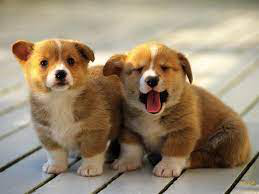

In [46]:
img = url_to_image(IMAGE_URL)
display(img)

2 is always better than one...

## Upload
Now we will use the URL of the image and the api to upload the image.

In [47]:
post_inputs_response = stub.PostInputs(
    service_pb2.PostInputsRequest(
        user_app_id=userDataObject,
        inputs=[
            resources_pb2.Input(
                data=resources_pb2.Data(image=resources_pb2.Image(url=IMAGE_URL, allow_duplicate_url=True))
            )
        ],
    ),
    metadata=metadata,
)

if post_inputs_response.status.code != status_code_pb2.SUCCESS:
    print(post_inputs_response.status)
    raise Exception("Post inputs failed, status: " + post_inputs_response.status.description)
else:
    print(f"Post inputs succeeded for: {IMAGE_URL}")


Post inputs succeeded for: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9E5o-bW_Njw6yvkP-dhviUlUuAHMio0QTbMKCcmJ1cLbxuR-BmAGcGtHUjCdgKKV2CNI&usqp=CAU


Let's view the response

In [48]:
post_inputs_response

status {
  code: SUCCESS
  description: "Ok"
  req_id: "e25df229cc32da91feab5ad40aaa4137"
}
inputs {
  id: "e5c22070dbbb4cc887a726a92c9a21da"
  data {
    image {
      url: "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9E5o-bW_Njw6yvkP-dhviUlUuAHMio0QTbMKCcmJ1cLbxuR-BmAGcGtHUjCdgKKV2CNI&usqp=CAU"
      image_info {
        format: "UnknownImageFormat"
        color_mode: "UnknownColorMode"
      }
    }
  }
  created_at {
    seconds: 1673540300
    nanos: 840514841
  }
  modified_at {
    seconds: 1673540300
    nanos: 840514841
  }
  status {
    code: INPUT_DOWNLOAD_PENDING
    description: "Download pending"
  }
}

# Add Inputs via Bytes (local files)
In this section, we will learn how to upload an input to the platform using a local image file.


## Download Image
First let's download a test image from the internet. 

In [49]:
!mkdir -p ./data
!wget -q -O ./data/test_image_1.jpg https://i.pinimg.com/originals/8b/53/55/8b5355a1bc9c446ad9a20cd80b930340.jpg

## View Image
Now that it is downloaded, we can view the image

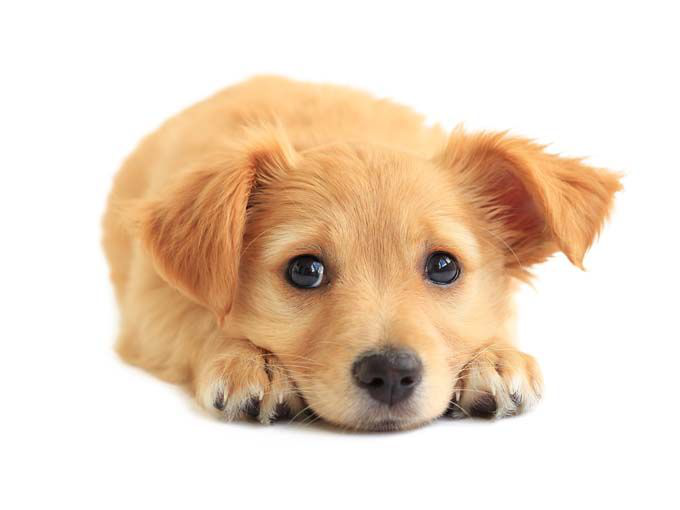

In [50]:
IMAGE_FILE_LOCATION = Path("./data/test_image_1.jpg")
img = local_path_to_image(IMAGE_FILE_LOCATION)
display(img)

Watch out not to crash the platform... from cuteness

## Upload
Now we will read the image file as bytes and use the api to upload the image.

In [51]:
# Read the image file as bytes
with open(IMAGE_FILE_LOCATION, "rb") as f:
    file_bytes = f.read()

# Call the API 
post_inputs_response = stub.PostInputs(
    service_pb2.PostInputsRequest(
        user_app_id=userDataObject,
        inputs=[resources_pb2.Input(data=resources_pb2.Data(image=resources_pb2.Image(base64=file_bytes)))],
    ),
    metadata=metadata,
)

# Validate the response to see if the API call was successful
if post_inputs_response.status.code != status_code_pb2.SUCCESS:
    print(post_inputs_response.status)
    print(post_inputs_response.status.description)
    raise Exception("Post inputs failed, status: " + post_inputs_response.status.description)
else:
    print(f"Post inputs succeeded for: {IMAGE_FILE_LOCATION}")

Post inputs succeeded for: data/test_image_1.jpg


Let's view the response

In [52]:
post_inputs_response

status {
  code: SUCCESS
  description: "Ok"
  req_id: "2297299857520ca0ded43430bf03bf13"
}
inputs {
  id: "8641b9a481ba4049bb038a55fdb649ec"
  data {
    image {
      url: "https://s3.amazonaws.com/clarifai-api/img3/prod/orig/244d85afc39345ee91620512f5af5066/edd1bd5c4e7db8aba0da1fa3b052b490"
      image_info {
        format: "UnknownImageFormat"
        color_mode: "UnknownColorMode"
      }
    }
  }
  created_at {
    seconds: 1673540304
    nanos: 570970386
  }
  modified_at {
    seconds: 1673540304
    nanos: 570970386
  }
  status {
    code: INPUT_DOWNLOAD_PENDING
    description: "Download pending"
  }
}

# Adding Inputs with Concept and Metadata

In this section, we will learn how to upload an input to the platform with a concept and metadata.


## Prepare
Let's prepare the concept and metadata we want to upload with the input. You can imagine for many images, you would store these information in a list or dataframe.

In [53]:
# This is the concept ID that will be uploaded with the input
CONCEPT_ID = "animal"  

# This is the metadata that will be uploaded with the input
CUSTOM_METADATA = {
    "id": "id001",
    "type": "animal",
    "size": 100,
}

# Build metadata protobuf struct object that will be uploaded with the image
input_metadata = build_metadata(**CUSTOM_METADATA)
input_metadata

fields {
  key: "id"
  value {
    string_value: "id001"
  }
}
fields {
  key: "size"
  value {
    number_value: 100.0
  }
}
fields {
  key: "type"
  value {
    string_value: "animal"
  }
}

## Upload
Now we will use the URL of the image and the api to upload the image.

In [54]:
# Let's first create the api request object
post_inputs_request = service_pb2.PostInputsRequest(
    user_app_id=userDataObject,
    inputs=[
        resources_pb2.Input(
            data=resources_pb2.Data(
                image=resources_pb2.Image(url=IMAGE_URL, allow_duplicate_url=True),
                concepts=[resources_pb2.Concept(id=CONCEPT_ID, value=1.0)],
                metadata=input_metadata,
            )
        )
    ],
)

# Call the API
post_inputs_response = stub.PostInputs(post_inputs_request, metadata=metadata)

# Validate that the request was successful
if post_inputs_response.status.code != status_code_pb2.SUCCESS:
    print(post_inputs_response.status)
    raise Exception("Post inputs failed, status: " + post_inputs_response.status.description)
else:
    print(f"Post inputs succeeded for: {IMAGE_URL}")

Post inputs succeeded for: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9E5o-bW_Njw6yvkP-dhviUlUuAHMio0QTbMKCcmJ1cLbxuR-BmAGcGtHUjCdgKKV2CNI&usqp=CAU


Let's view the response

In [55]:
post_inputs_response

status {
  code: SUCCESS
  description: "Ok"
  req_id: "0b1323f9acc19acc68b9fd8df8e12873"
}
inputs {
  id: "2de5ad0213db4e5f94119af3f87a7b96"
  data {
    image {
      url: "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR9E5o-bW_Njw6yvkP-dhviUlUuAHMio0QTbMKCcmJ1cLbxuR-BmAGcGtHUjCdgKKV2CNI&usqp=CAU"
      image_info {
        format: "UnknownImageFormat"
        color_mode: "UnknownColorMode"
      }
    }
    concepts {
      id: "animal"
      name: "animal"
      value: 1.0
      app_id: "nytimes-test-app"
    }
    metadata {
      fields {
        key: "id"
        value {
          string_value: "id001"
        }
      }
      fields {
        key: "size"
        value {
          number_value: 100.0
        }
      }
      fields {
        key: "type"
        value {
          string_value: "animal"
        }
      }
    }
  }
  created_at {
    seconds: 1673540306
    nanos: 548644313
  }
  modified_at {
    seconds: 1673540306
    nanos: 548644313
  }
  status {
    co

# Uploading Multiple Images

In this section, we will learn how to upload multiple local images. You can upload the images one at a time or by batches.


Let's first download some test images.


In [56]:
!mkdir -p ./data

!wget -q -O ./data/test_image_1.jpg https://i.pinimg.com/originals/8b/53/55/8b5355a1bc9c446ad9a20cd80b930340.jpg
!wget -q -O ./data/test_image_2.jpg https://paradepets.com/.image/t_share/MTkxMzY1Nzg5MjI1NTI2ODE3/small-cat-breeds-1-jpg.jpg
!wget -q -O ./data/test_image_3.jpg https://www.rd.com/wp-content/uploads/2021/02/GettyImages-1214226685-e1612808565854.jpg
!wget -q -O ./data/test_image_4.jpg https://i.pinimg.com/originals/44/d9/8c/44d98cccb725fd3a80c0446b9b2e646d.jpg
!wget -q -O ./data/test_image_5.jpg https://www.akc.org/wp-content/uploads/2017/11/GettyImages-187066830.jpg
!wget -q -O ./data/test_image_6.jpg https://thehappypuppysite.com/wp-content/uploads/2020/12/What-is-considered-a-small-dog-HP-long.jpg

## Getting Image Paths

Here we will be getting all local paths to the downloaded images.


In [57]:
DATA_DIR = Path("./data/")
file_types = ("*.jpg", "*.jpeg", "*.tiff", "*.png")  # Add more extensions if needed

IMAGE_PATHS = []
for file_type in file_types:
    IMAGE_PATHS.extend(glob.glob(str(DATA_DIR / file_type)))

IMAGE_PATHS = [Path(image_path) for image_path in IMAGE_PATHS]
len(IMAGE_PATHS)

6

Let's check to see if the paths are correct. We are expecting 6 images under the `/data/` directory.


In [58]:
IMAGE_PATHS

[PosixPath('data/test_image_3.jpg'),
 PosixPath('data/test_image_2.jpg'),
 PosixPath('data/test_image_1.jpg'),
 PosixPath('data/test_image_5.jpg'),
 PosixPath('data/test_image_4.jpg'),
 PosixPath('data/test_image_6.jpg')]

## Single image upload

This sub-section uploads the images one at a time. This is useful when you have to upload only a few images. It gives you more control and is easier to debug than batch uploads.


In [59]:
for image_path in tqdm(IMAGE_PATHS, total=len(IMAGE_PATHS), desc="Uploading Images"):
     # Note that we are passing a list of image paths to the function. post_inputs expects a list of images since it can also do batch.
    post_inputs(stub, metadata, [image_path])
print("Done!")

Uploading Images:   0%|          | 0/6 [00:00<?, ?it/s]

Done!


## Batch upload

This sub-section uploads the images in batches. This is useful when you have a larger amount of images (>=1000). It reduces the upload time considerably.


In [60]:
# Change this to a higher number if you want to upload more images at once. Recommended 4,8,16
batch_size = 2

# Calculate the number of batches we expect to upload
expected_batch_nums = calculate_expected_batch_number(IMAGE_PATHS, batch_size)
print("expected_batch_nums: ", expected_batch_nums)

# Iterate over the image paths in batches
for image_chunk_list in tqdm(
    chunker(IMAGE_PATHS, batch_size), total=expected_batch_nums, desc="Uploading Images"
):
    print(f"Uploading {len(image_chunk_list)} images")

    # Call the api and upload the batch of images
    post_inputs(stub, metadata, image_chunk_list)

print("Done!")

expected_batch_nums:  3


Uploading Images:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading 2 images
Uploading 2 images
Uploading 2 images
Done!


## Uploading images with concepts and metadata
Let's create dummy metadata for each of the inputs (should be 6).


In [61]:
input_metadata_list = [
    {f"extension": image_path.suffix} for idx, image_path in enumerate(IMAGE_PATHS)
]
input_metadata_list

[{'extension': '.jpg'},
 {'extension': '.jpg'},
 {'extension': '.jpg'},
 {'extension': '.jpg'},
 {'extension': '.jpg'},
 {'extension': '.jpg'}]

Let's also create the list of concepts. Each item of the list corresponds to an image. 

In [62]:
concept_list = ["cat", "dog", "dog", "both", "dog", "cat"]

In [63]:
dataset_gen = zip(IMAGE_PATHS, concept_list, input_metadata_list)
dataset = list(dataset_gen)

In [64]:
# Change this to a higher number if you want to upload more images at once. Recommended 4,8,16
batch_size = 2

# Calculate the number of batches we expect to upload
expected_batch_nums = calculate_expected_batch_number(dataset, batch_size)
print("expected_batch_nums: ", expected_batch_nums)

# Iterate over the image paths in batches
for dataset_chunk in tqdm(chunker(dataset, batch_size), total=expected_batch_nums, desc="Uploading Images"):
    # Unpack the batch and covert to list
    image_chunk_list, concepts, inputs_metadata = list(zip(*dataset_chunk))
    image_chunk_list = list(image_chunk_list)
    concepts = list(concepts)
    input_metadata = list(inputs_metadata)

    print(f"Uploading {len(image_chunk_list)} images")

    # Call the api and upload the batch of images
    post_inputs(stub, metadata, image_chunk_list, concepts, inputs_metadata)

print("Done!")


expected_batch_nums:  3


Uploading Images:   0%|          | 0/3 [00:00<?, ?it/s]

Uploading 2 images
Uploading 2 images
Uploading 2 images
Done!
